# Change in Premature Mortality Incidence At the County Level

In [1]:
import requests
import pandas as pd
from censusdis.datasets import ACS5
from censusdis.states import ABBREVIATIONS_FROM_IDS, IDS_FROM_ABBREVIATIONS
import censusdis.data as ced
import censusdis.maps as cem
import ipywidgets as widgets
from IPython.display import display

from pathlib import Path

BASE_URL = "https://api.rewiringamerica.org/api/v1/health_impacts"

API_KEY = None  # Put your API key here, or better yet in the file ~/.rwapi/api_key.txt

In [2]:
if API_KEY is None:
    api_key_path = Path.home() / ".rwapi" / "api_key.txt"

    if api_key_path.is_file():
        with open(api_key_path) as f:
            API_KEY = f.read().strip()

In [3]:
state_widget = widgets.Dropdown(
    options=sorted([v for v in ABBREVIATIONS_FROM_IDS.values() if v not in ["AK", "HI"]]),
    description="State: ",
    disabled=False,
    value="NJ",
)
upgrade_widget = widgets.Dropdown(
    options=[
        (name, value) for name, value in zip(
            [
                "Heat Pump Dryer",
                "Medium Efficiency Heat Pump + Basic Insulation",
                "Heat Pump Water Heater",
                "Medium Efficiency Heat Pump",
                "Electric Resistance Dryer",
            ],
            [
                "hp_dryer",
                "med_eff_hp_hers_sizing_no_setback_basic_enclosure",
                "hp_water_heater",
                "med_eff_hp_hers_sizing_no_setback",
                "electric_resistance_dryer",
            ],
        )
    ],
    description="Upgrade: ",
    disabled=False,
    value="med_eff_hp_hers_sizing_no_setback_basic_enclosure",
)
display(state_widget)
display(upgrade_widget)

Dropdown(description='State: ', index=29, options=('AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',…

Dropdown(description='Upgrade: ', index=1, options=(('Heat Pump Dryer', 'hp_dryer'), ('Medium Efficiency Heat …

## Call the RA API

1. Construct the URL and call the API.
2. Put the returned data into a data frame.

In [4]:
url = (
    f"{BASE_URL}/"
    f"?metrics=premature_mortality_incidence_delta"
    f"&upgrade={upgrade_widget.value}"
    f"&county_fips=%2A" 
    f"&state={state_widget.value}"
)

headers = {"Authorization": f"Bearer {API_KEY}"}

results = requests.get(url, headers=headers)

In [5]:
df_data = pd.DataFrame(results.json()['data'])
df_data.head()

,state,premature_mortality_incidence_delta,county,number_of_households
0,NJ,2.823742,001,91768
1,NJ,57.616695,003,330509
2,NJ,16.622207,005,153027
3,NJ,24.511569,007,176998
4,NJ,0.848970,009,38257


## Get the map data

1. Get the census map data.
2. Merge with the health data.

In [6]:
state = IDS_FROM_ABBREVIATIONS[state_widget.value]

In [7]:
gdf_counties = ced.download(ACS5, 2022, ["NAME"], state=state, county="*", with_geometry=True)

In [8]:
df_data["STATE"] = df_data["state"].map(IDS_FROM_ABBREVIATIONS)
df_data["COUNTY"] = df_data["county"]

In [9]:
gdf_map = gdf_counties.merge(df_data, on=["STATE", "COUNTY"])

## Plot the map

With appropriate styling.

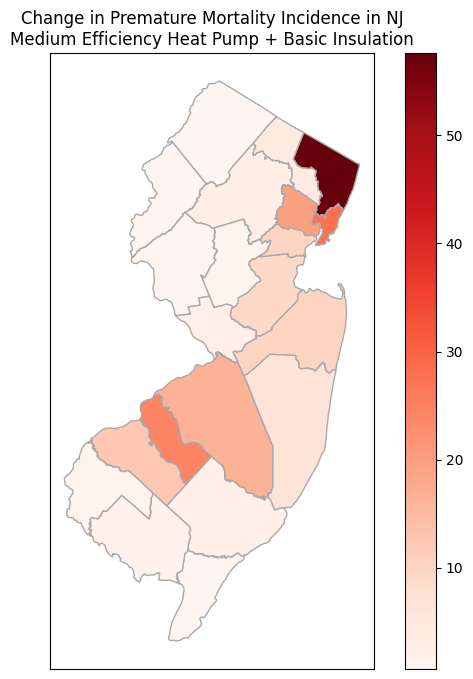

In [10]:
ax = cem.plot_map(
    gdf_map,
    "premature_mortality_incidence_delta",
    cmap="Reds",
    edgecolor="darkgray",
    figsize=(8, 8),
    legend=True
)

ax.set_title(f"Change in Premature Mortality Incidence in {state_widget.value}\n{upgrade_widget.label}");